In [270]:
# PyTorch의 핵심 라이브러리를 불러옴.
import torch
# PyTorch의 자동 미분 기능(Autograd)을 위한 Variable 클래스를 불러옴. (최신 PyTorch에서는 텐서가 대체함)
from torch.autograd import Variable
# 신경망 레이어(nn) 모듈을 불러옴.
import torch.nn as nn
# 함수형 신경망 연산(F) 모듈을 불러옴.
import torch.nn.functional as F
# 옵티마이저(optim) 모듈을 불러옴.
from torch import optim


# TorchVision 라이브러리를 불러옴.
import torchvision
# 이미지 변환(transforms) 모듈을 불러옴.
from torchvision import transforms


# PIL 라이브러리의 Image 모듈을 불러옴. 이미지 처리에 사용함.
from PIL import Image
# 순서가 보장되는 딕셔너리(OrderedDict) 클래스를 불러옴. (특정 구조 저장에 유용함)
from collections import OrderedDict



In [271]:

size = (1, 3, 2,2)
input = torch.randn(size)
b, c, h, w = input.size()
f = input.view(b,c,h*w)
f.shape
f.transpose(1,2).shape
G = torch.bmm(f, f.transpose(1,2))
G.div_(h*w)

tensor([[[ 1.6293,  0.4843,  0.4474],
         [ 0.4843,  0.3921, -0.0226],
         [ 0.4474, -0.0226,  0.5550]]])

In [272]:
f,f.transpose(1,2)

(tensor([[[-2.1592,  0.9548,  0.9267, -0.2909],
          [-0.2323,  0.8784,  0.4055, -0.7607],
          [-1.0805,  0.3833, -0.8426,  0.4422]]]),
 tensor([[[-2.1592, -0.2323, -1.0805],
          [ 0.9548,  0.8784,  0.3833],
          [ 0.9267,  0.4055, -0.8426],
          [-0.2909, -0.7607,  0.4422]]]))

In [273]:
# GRAM MATRIX 계산
class GramMatrix(nn.Module):
    def forward(self, input): # input은 feature 맵
        # 입력 텐서 batch, channel, height, width 추출
        b, c, h, w = input.size()

        # 텐서를 (batch, channel, height*width) 형태로 flatten(평탄화)함
        # 이 구현에서 batch 차원은 유지하고 channel 차원만 평탄화해야 함 (b, c, h*w)
        F = input.view(b,c,h*w)

        # 배치 행렬 곱셈(bmm) 사용, gram matrix G 계산
        # F와 F의 채널-공간 차원 전치를 곱함, 결과크기 (b,c,c)
        # 원래 F.shape = (b,c,h*w) h*w를 n 이라고 하면 (b,c,n)
        # 두 feature map 간의 내적하면 (b,c,c)
        # 이게 무엇을 의미하는가? batch_size는 남겨두고 c,c 채널 간 상관관계 파악
        # i번째 채널과 j번째 채널이 얼마나 이미지에 동시에 활성화 되었는가 파악
        # 여기서 잠깐 잊지 말자. w*h=n이 였는데 없어졌네 (위치정보 제거)
        # 위치 필요없어. 오직 스타일뿐 (질감, 색상)
        G = torch.bmm(F, F.transpose(1,2)) # bmm는 batch는 남겨두고 뒤에 두 행렬 끼리 곱

        # Gram matrix를 height * width 나누어요 >> 정규화
        G.div_(h*w)

        return G # (b, c, c) 행렬 반환

# Gram Matrix 이용, MSE(평균 제곱 오차) 손실을 계산하는 모듈 정의
class GramMSELoss(nn.Module):
    def forward(self, input, target): # 
        # GramMatrix 모듈 통과 gram matrix 계산함
        # >> 목표(target) gram matrix MSE 손실 계산
        out = nn.MSELoss()(GramMatrix()(input), target)

        return out

In [274]:
vgg_trained = torchvision.models.vgg16_bn(pretrained=True)
for p in vgg_trained.parameters():
    p.requires_grad = False
vgg_trained.eval()

/home/kim/miniconda3/envs/yolo_env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/kim/miniconda3/envs/yolo_env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [275]:
count = 0
for name, layer in vgg_trained.features._modules.items():
    print(name)
    if layer.__class__.__name__ == "ReLU":
        print(layer.__class__.__name__)
    count += 1
    if count == 5:
        break

0
1
2
ReLU
3
4


In [276]:
class VGGFeature(nn.Module):
    def __init__(self,vgg):
        super().__init__()
        self.vgg = vgg.features
    def forward(self, x, out_keys):
        out = []
        for name, layer in self.vgg._modules.items():
            x = layer(x)
            if layer.__class__.__name__ == "ReLU":
                out.append(x)
        return [out[key] for key in out_keys]

In [277]:
class VGG(nn.Module):
    def __init__(self, pool='max'):
        super(VGG, self).__init__()
        #vgg modules
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        if pool == 'max':
            self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        elif pool == 'avg':
            self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool3 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool4 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool5 = nn.AvgPool2d(kernel_size=2, stride=2)

# 0, 2, 4, 5, 12
    def forward(self, x, out_keys):
        out = {}
        out['r11'] = F.relu(self.conv1_1(x))
        out['r12'] = F.relu(self.conv1_2(out['r11']))
        out['p1'] = self.pool1(out['r12'])
        out['r21'] = F.relu(self.conv2_1(out['p1']))
        out['r22'] = F.relu(self.conv2_2(out['r21']))
        out['p2'] = self.pool2(out['r22'])
        out['r31'] = F.relu(self.conv3_1(out['p2']))
        out['r32'] = F.relu(self.conv3_2(out['r31']))
        out['r33'] = F.relu(self.conv3_3(out['r32']))
        out['r34'] = F.relu(self.conv3_4(out['r33']))
        out['p3'] = self.pool3(out['r34'])
        out['r41'] = F.relu(self.conv4_1(out['p3']))
        out['r42'] = F.relu(self.conv4_2(out['r41']))
        out['r43'] = F.relu(self.conv4_3(out['r42']))
        out['r44'] = F.relu(self.conv4_4(out['r43']))
        out['p4'] = self.pool4(out['r44'])
        out['r51'] = F.relu(self.conv5_1(out['p4']))
        out['r52'] = F.relu(self.conv5_2(out['r51']))
        out['r53'] = F.relu(self.conv5_3(out['r52']))
        out['r54'] = F.relu(self.conv5_4(out['r53']))
        out['p5'] = self.pool5(out['r54'])
        return [out[key] for key in out_keys]

In [278]:
import matplotlib.pyplot as plt

In [279]:
vgg = VGGFeature(vgg_trained)

# 로드할 이미지 파일 이름들을 정의함. ('vangogh_starry_night.jpg', 'Tuebingen_Neckarfront.jpg')
img1 = '/home/kim/Desktop/AI_cours/data/vangogh_starry_night.jpg'
img2 = '/home/kim/Downloads/apel.jpg'


# 이미지 디렉토리와 파일 이름을 결합하여 PIL Image 객체 리스트로 로드함.
img1 = Image.open(img1)
img2 = Image.open(img2)
imgs = []
imgs.append(img1)
imgs.append(img2)

# plt.imshow(img2)

In [280]:
img_size = 512

prep = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), # RGB >> BGR 변환
    transforms.Normalize([0.407,0.458,0.485],[1,1,1]),
    transforms.Lambda(lambda x: x.mul_(255))
])

# 각 PIL Image 객체에 사전 정의된 전처리 함수 적용
imgs_torch = [prep(img) for img in imgs]

# if torch.cuda.is_available():
#     imgs_torch = [Variable(img.unsqueeze(0).cuda()) for img in imgs_torch]
#     # 배치차원만 추가 >> Variable(자동미분 기능 포함) 저장
# else:
#     imgs_torch = [Variable(img.unsqueeze(0)) for img in imgs_torch]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
imgs_torch = [img.unsqueeze(0).to(device) for img in imgs_torch]

# 이미지 텐서 리스트를 스타일 이미지와 콘텐츠 이미지 변수에 할당
style_image, content_image = imgs_torch

# opt_img = Variable(content_image.data.clone(), requires_grad=True)
# 콘텐츠 이미지의 데이터 복사본으로 최적화하기 위해 초기화함
# requires_grad=True 이 이미지 픽셀을 최적화하여 학습하도록 하겠다.

opt_img = content_image.detach().clone().requires_grad_(True)
# detach() 자동미분 계산하면서 이전 계산 기록을 끊어내기 위해
# requires_grad_(True) 모델의 가중치 변경하는 게 아님 이미지가 가진 pixel 학습대상

In [281]:
import torch
import torch.nn as nn

vgg = vgg.to(device)

# 스타일 손실 계산할 vgg layer 이름 정의
# r11, r21 >> vgg 내부의 특징 합성곱 레이어 나타냄(relu 통과한 층)
# 낮은 레이어 (이미지의 아주 세밀한 형태 경계선, 점, 색상)
# style_layers = ['r11', 'r21', 'r31', 'r41', 'r51']
style_layers = [0, 2, 4, 5, 12]

# 콘텐츠 손실 계산할 VGG layer 이름 정의
# 일반적으로 중간 레이어 하나 사용
# 왜? 객체의 눈, 코, 입 전체적인 윤곽
# content_layers = ['r42']
content_layers = [9]

loss_layers = style_layers + content_layers
# 사용할 모든 손실 에리어 = 스타일 손실 + 콘텐츠 손실

# 각 스타일에 대해 GramMSELoss 모듈 적용
# 콘텐츠에 대해서는 MSELoss 모듈 사용

loss_fn = [GramMSELoss()] * len(style_layers) + [nn.MSELoss()] * len(content_layers)

if torch.cuda.is_available():
    # loss_fns 리스트의 요소들을 새로운 모듈 인스턴스로 만들고 .cuda() 적용
    # 리스트 복사를 방지하고 정확하게 gpu로 이동하기 위해 수정
    loss_fns = [GramMSELoss().to(device) for _ in style_layers] + [nn.MSELoss().to(device) for _ in content_layers]

else:
    loss_fns = [GramMSELoss().to(device) for _ in style_layers] + [nn.MSELoss().to(device) for _ in content_layers]

# 스타일 손실에 부여할 가중치 정의함
# 깊은 레이어일 수록 낮은 가중치를 주는 경향이 있음
# >> 최종적으로 스타일 손실은 (b, c, c)
# >> 채널수가 적은 쪽에 낮은 가중치, 채널수가 많은 뒤쪽에는 작은 가중치를 부여해야
# >> 전체적인 손실 규모를 맞춰주게 됨 >> 일종의 정규화 효과
# n은 채널 수
style_weights = [1e3/n**2 for n in [64, 128, 256, 256, 512]]

# 콘텐츠 손실에 부여할 가중치(weights) 정의
content_weights = [1e0]

# 최종으로 사용할 모든 가중치 리스트
weights = style_weights + content_weights

# 최적화 목표값(style targets) 계산
style_targets = [GramMatrix()(A).detach() for A in vgg(style_image, style_layers)] # A는 피쳐맵, 결과값(b, c, c)

style_weights = [1e1, 1e2,1e2,1e3,1e3]
style_weights = [1e3/style_targets[i].shape[-1]**2 for i in range(len(style_targets))]

# 최적화 목표값(content targets) 계산
content_targets = [A.detach() for A in vgg(content_image, content_layers)] # 피쳐맵(b, c, w, h)

# 최종적으로 사용할 모든 목표값 리스트 정의
targets = style_targets + content_targets # 리스트[style_targets, content_targets]


In [282]:
content_targets[0].shape

torch.Size([1, 512, 64, 64])

In [283]:
style_weights = [1e3/style_targets[i].shape[-1]**2 for i in range(len(style_targets))]
style_weights

[0.244140625,
 0.06103515625,
 0.0152587890625,
 0.0152587890625,
 0.003814697265625]

In [284]:
input_image = content_image.clone().requires_grad_(True)
# input_image는 vgg에 입력될 초기 이미지, 콘텐츠 이미지와 동일한 형태여야함

In [285]:
optimizer = torch.optim.LBFGS([input_image], max_iter=1)
# LBFGS 사용하면 closure() 사용해야 함
# LBFGS 특징 : 2차미분(헤시안 Hessian) 근사치 사용 (극소값, 극대값, 안장값 판별)
# 헤시안 행렬은 말 그대로 2차미분 즉 얼마나 휘어졌는지 알 수 있다.
# 왜 Adam보다 선호되는가? 헤시안 사용하여 근사치를 구한 결과가 더 정교하고 빠르게 최적의 픽셀 값을 찾아내는 데 도움
# 우리는 단 1장의 이미지(input_image)만 최적화하면 됨(원래는 배치단위로 많이했음)
# LBFGS는 적은 데이터에 더 선명하고 고품질의 결과물을 가져오는 경향이 있음


In [286]:
# 최적화 횟수를 세기 위한 변수
n_iter = 0

In [287]:
def closuer():
    global n_iter

    optimizer.zero_grad()

    # 생성된 이미지(input_image)를 VGG 통과 >> 특징맵 생성
    out = vgg(input_image, loss_layers)

    # 총손실 계산
    layer_losses = []
    total_loss = 0

    for i, weight in enumerate(weights):
        target = targets[i]
        feature = out[i]
        loss_fn = loss_fns[i]

        loss = weight * loss_fn(feature, target)
        layer_losses.append(loss.item())
        total_loss += loss
    
    # 역전파 수행
    total_loss.backward()

    # 진행상황 출력
    if n_iter%50 == 0:
        print(f'lteration {n_iter}: Total loss={total_loss.item():.4f}')
    
    n_iter += 1
    return total_loss

In [288]:
# 최적화 실행(반복 횟수 지정)
num_iterations = 500

for i in range(num_iterations):
    optimizer.step(closure=closuer)
    # input_image.data.clamp_(0,1)
    # LBFGS는 step() 호출 할 때마다 closure() 여러 번 호출 가능

# 최종 결과 이미지 후처리
# 생성된 이미지를 [0,1] 범위로 클리핑하여 픽셀값 보정
input_image.data.clamp_(0,1)

lteration 0: Total loss=1312.9615
lteration 50: Total loss=0.1412
lteration 100: Total loss=0.0523
lteration 150: Total loss=0.0318
lteration 200: Total loss=0.0237
lteration 250: Total loss=0.0193
lteration 300: Total loss=0.0165
lteration 350: Total loss=0.0147
lteration 400: Total loss=0.0133
lteration 450: Total loss=0.0126


tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [0.9403, 1.0000, 0.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.0000, 1.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.0000, 1.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.0000, 1.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.0000, 1.0000],
          [0.0000, 0.0000, 0.0000,  ..., 1.0000, 1.0000, 1.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.0000, 1.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.0000, 1.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.0000, 1.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.0000, 1.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.0000, 1.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0

In [289]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import numpy as np

def imshow(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0) # 배치차원 제거 (1,c,h,w) >> (c,h,w)
    unloader = transforms.ToPILImage() # PIL 이미지로 변경
    image = image[[2, 1, 0], :, :]
    image = unloader(image)

    if title is not None:
        plt.title(title)
    
    plt.imshow(image)
    # plt.pause(0.001) # 잠시 멈춰서 그림 보여줘

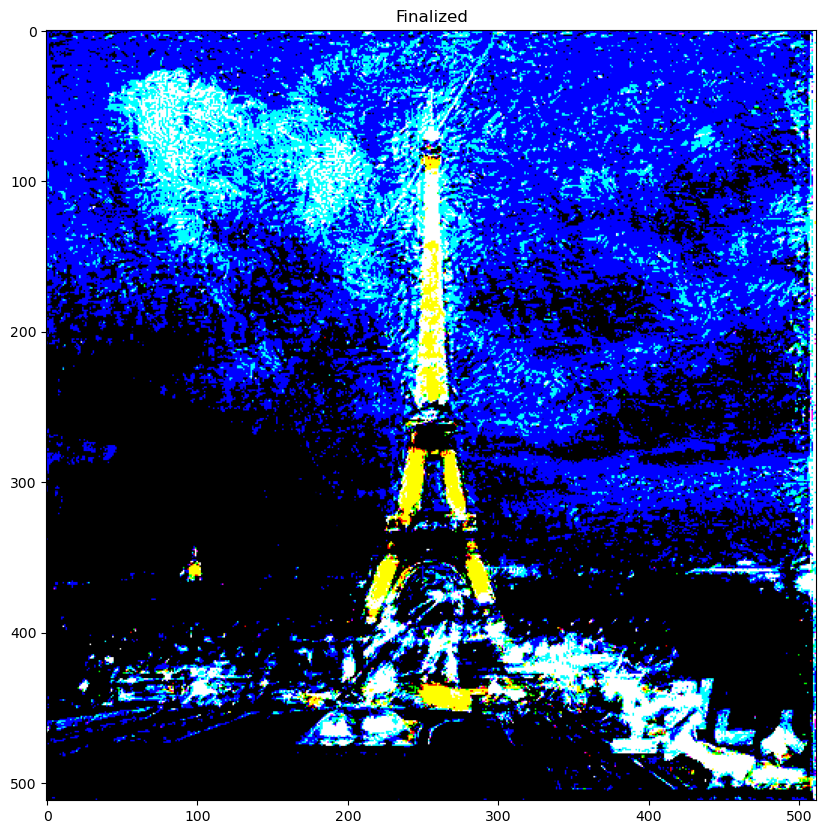

In [290]:
plt.figure(figsize=(10,10))
imshow(input_image.data, title='Finalized')
plt.show()

In [291]:
import numpy as np
_ = np.array([
    [
        [1,1,1],
        [1,1,1],
        [1,1,1]
    ],
    [
        [2,2,2],
        [2,2,2],
        [2,2,2]
    ],
    [
        [3,3,3],
        [3,3,3],
        [3,3,3]
    ]
])

In [292]:
_[[2,1,0]]

array([[[3, 3, 3],
        [3, 3, 3],
        [3, 3, 3]],

       [[2, 2, 2],
        [2, 2, 2],
        [2, 2, 2]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]]])